In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir("/content/drive/My Drive/digits_recognition")
os.getcwd()

'/content/drive/My Drive/digits_recognition'

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D,Dropout, BatchNormalization

import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import to_categorical
import numpy as np
from PIL import Image, ImageEnhance, ImageOps
import skimage
import cv2

from scipy import ndimage, misc

import os
import imgaug.augmenters as iaa
import imgaug as ia
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [4]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

Тут надо сконвертить в черные цифры на белом фоне

In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = 255 - X_train
X_test = 255 - X_test

In [0]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq_not_7_1 = iaa.Sequential([
    sometimes(iaa.GaussianBlur(sigma=(0, 0.5))),
     iaa.OneOf([iaa.CropAndPad(
            percent=(-0.25, 0.25),
            pad_mode=["constant", "edge"],
            pad_cval=(0, 128)
    ),
            iaa.CropAndPad(
            percent=(-0.25, 0),
            pad_mode=["constant"],
            pad_cval=(0)
    ),
            iaa.CropAndPad(
            percent=(-0.25, 0),
            pad_mode=["constant"],
            pad_cval=(255)
    )
               ]),
    sometimes(iaa.Affine(
            scale={"x": (0.8, 1.3), "y": (0.8, 1.3)}, 
            rotate=(-30, 30), 
        )),
    sometimes((iaa.SaltAndPepper(0.1))),
    
], random_order=True)


seq_7_1 = iaa.Sequential([
    sometimes(iaa.GaussianBlur(sigma=(0, 0.5))),
     iaa.OneOf([iaa.CropAndPad(
            percent=(-0.25, 0.25),
            pad_mode=["constant", "edge"],
            pad_cval=(0, 128)
    ),
            iaa.CropAndPad(
            percent=(-0.25, 0),
            pad_mode=["constant"],
            pad_cval=(0)
    ),
            iaa.CropAndPad(
            percent=(-0.25, 0),
            pad_mode=["constant"],
            pad_cval=(255)
    )
               ]),
    sometimes(iaa.Affine(
            scale={"x": (0.95, 1.05), "y": (0.95, 1.05)}, 
            rotate=(-2, 2), 
        )),
    sometimes((iaa.SaltAndPepper(0.1))),
    
], random_order=True)



`our_sample_digits` – папка, в ней сложены наши семплы картинок, которые у нас получились из вырезок настоящих бланков

In [0]:
digits_to_add = dict()

for filename in os.listdir("our_sample_digits"):
    if ".png" in filename:
        filepath = "our_sample_digits/{}".format(filename)
        im=Image.open(filepath)
        im=im.resize((28 ,28),Image.ANTIALIAS)
        im = np.array(im)
        if im.shape != (28, 28):
            im = np.mean(im, axis=2)

        digit = filename[0]
        current_digits = digits_to_add.get(digit, [])
        current_digits.append(im)
        digits_to_add[digit] = current_digits
        

In [0]:
X_train_self_created = []
y_train_self_created = []


sample_size = int(30000 / 10)
for i in range(10):
    y_s = sample_size * [i]
    x_s = digits_to_add[str(i)]
    x_s = np.array(x_s)
    row_i = np.random.choice(x_s.shape[0],size=sample_size)
    x_s = x_s[row_i]
    x_s = list(x_s)
    #x_s = np.random.choice(, sample_size)
    X_train_self_created += x_s
    y_train_self_created += y_s


In [0]:
X_test_self_created = []
y_test_self_created = []


sample_size = int(10000/10)
for i in range(10):
    y_s = sample_size * [i]
    x_s = digits_to_add[str(i)]
    x_s = np.array(x_s)
    row_i = np.random.choice(x_s.shape[0],size=sample_size)
    x_s = x_s[row_i]
    x_s = list(x_s)
    #x_s = np.random.choice(, sample_size)
    X_test_self_created += x_s
    y_test_self_created += y_s


Очищение отсканированных "настоящих" картинок: увеличение контрастности, уменьшение шума 

In [0]:
def pretty_scanned_digit(image_array):

    im = Image.fromarray(image_array.astype(np.uint8))
    im_from_array = im.resize((28 ,28),Image.ANTIALIAS)
    gray_image_for_prediction = np.array(im_from_array).reshape(28, 28)
    return gray_image_for_prediction

In [0]:
X_train_self_created = list(map(pretty_scanned_digit, X_train_self_created))

X_test_self_created = list(map(pretty_scanned_digit, X_test_self_created))



In [0]:
X_train = np.concatenate([X_train, X_train_self_created])
X_test = np.concatenate([X_test, X_test_self_created])

y_train = np.concatenate([y_train, y_train_self_created])
y_test = np.concatenate([y_test, y_test_self_created])

In [98]:
X_train.shape

(90000, 28, 28)

In [99]:
X_test.shape

(20000, 28, 28)

In [0]:
necessary_train_size = 1000000

In [0]:
train_choice = np.random.choice(X_train.shape[0],size=necessary_train_size)

In [0]:
X_train_choosen = X_train[train_choice]
y_train_choosen = y_train[train_choice]

In [0]:
mask_1_7 = np.isin(y_train_choosen, [1, 7])
mask_not_1_7 = ~np.isin(y_train_choosen, [1, 7])

In [0]:
X_train_1_7 = X_train_choosen[mask_1_7]
y_train_1_7 = y_train_choosen[mask_1_7]

X_train_not_1_7 = X_train_choosen[mask_not_1_7]
y_train_not_1_7 = y_train_choosen[mask_not_1_7]

In [109]:
X_train_1_7 = seq_7_1(images=X_train_1_7)
print("1_7 were processed")
X_train_not_1_7 = seq_not_7_1(images=X_train_not_1_7)
print("not 1_7 were processed")

1_7 were processed
not 1_7 were processed


In [0]:
X_train_choosen = np.concatenate([X_train_1_7, X_train_not_1_7])
y_train_choosen = np.concatenate([y_train_1_7, y_train_not_1_7])

In [0]:
X_train_choosen = X_train_choosen.reshape(X_train_choosen.shape[0],28,28, 1)
X_test = X_test.reshape(X_test.shape[0],28,28, 1)

In [0]:
y_train_choosen = to_categorical(y_train_choosen)
y_test = to_categorical(y_test)

In [0]:
checkpoint = ModelCheckpoint("best_great_model_sep_1_7.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

In [0]:
model = Sequential()

model.add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size = 4, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.4))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [120]:
model.fit(X_train_choosen, y_train_choosen, validation_data=(X_test, y_test), 
          epochs=20,  shuffle=True, callbacks=[checkpoint], batch_size=100)
model.save_weights('mnist_mega_model_4_sep_1_7')
model_json = model.to_json()
open("mnist_mega_model_4_sep_1_7.json", "w").write(model_json)

Train on 1000000 samples, validate on 20000 samples
Epoch 1/20
1000000/1000000 [==============================] - 173s 173us/step - loss: 0.1946 - accuracy: 0.9424 - val_loss: 0.0265 - val_accuracy: 0.9932

Epoch 00001: loss improved from inf to 0.19458, saving model to best_great_model_sep_1_7.hdf5
Epoch 2/20
1000000/1000000 [==============================] - 170s 170us/step - loss: 0.1256 - accuracy: 0.9631 - val_loss: 0.0159 - val_accuracy: 0.9953

Epoch 00002: loss improved from 0.19458 to 0.12557, saving model to best_great_model_sep_1_7.hdf5
Epoch 3/20
1000000/1000000 [==============================] - 169s 169us/step - loss: 0.1028 - accuracy: 0.9699 - val_loss: 0.0181 - val_accuracy: 0.9947

Epoch 00003: loss improved from 0.12557 to 0.10277, saving model to best_great_model_sep_1_7.hdf5
Epoch 4/20
1000000/1000000 [==============================] - 169s 169us/step - loss: 0.0909 - accuracy: 0.9736 - val_loss: 0.0173 - val_accuracy: 0.9937

Epoch 00004: loss improved from 0.1027

10588

In [0]:
model.save_weights('mnist_mega_model_1')

In [0]:
model_json = model.to_json()
open("mnist_mega_model_1.json", "w").write(model_json)

In [0]:
def process_image_before_recognizing(filename):
    delta = 0
    separator = 120
    im = Image.open(filename)
    initial_image = Image.open(filename)
    enhancer = ImageEnhance.Contrast(im)

    factor = 10
    im = np.array(enhancer.enhance(factor))
    
    morph = im.copy()

    gray_image = np.min(im, axis=2)
    #plt.imshow(foo, "gray")

    result = ndimage.gaussian_filter(gray_image, 0)
    #result = ndimage.minimum_filter(result, size=3)

    #foo = Image.open("seven.png")
    #foo = foo.resize((28 +2 * delta,28 + 2 * delta), Image.NEAREST)
    #im = np.array(foo)
    #gray_image = np.min(im, axis=2)
    #gray_image = gray_image[: , : ]
    gray_image_for_prediction=result
    im_from_array = Image.fromarray(gray_image_for_prediction)
    im_from_array = im_from_array.resize((28 +2 * delta,28 + 2 * delta),Image.ANTIALIAS)
    #gray_image = (gray_image) * (20 / 255)
    gray_image_for_prediction = np.array(im_from_array).reshape(28, 28)
    gray_image_for_prediction[gray_image_for_prediction > separator] = 255
    return gray_image_for_prediction

In [0]:
def recognize_and_print_digit(filename):
    delta = 0
    separator = 120
    im = Image.open(filename)
    initial_image = Image.open(filename)
    enhancer = ImageEnhance.Contrast(im)

    factor = 10
    im = np.array(enhancer.enhance(factor))
    
    morph = im.copy()

    gray_image = np.min(im, axis=2)

    result = ndimage.gaussian_filter(gray_image, 0)

    gray_image_for_prediction=result
    im_from_array = Image.fromarray(gray_image_for_prediction)
    im_from_array = im_from_array.resize((28 +2 * delta,28 + 2 * delta),Image.ANTIALIAS)
    gray_image_for_prediction = np.array(im_from_array).reshape(28, 28)
    gray_image_for_prediction[gray_image_for_prediction > separator] = 255
    print(np.argmax(model.predict(gray_image_for_prediction.reshape(1, 28, 28, 1))),
         np.max(model.predict(gray_image_for_prediction.reshape(1, 28, 28, 1))))
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(gray_image_for_prediction, "gray")
    ax[1].imshow(initial_image)
    plt.show()

2 0.9999864


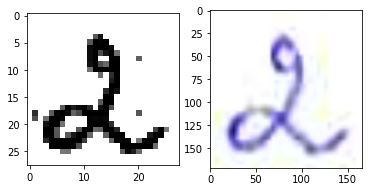

6 0.6505352


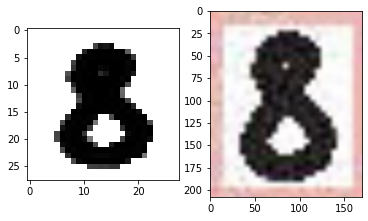

0 0.9999627


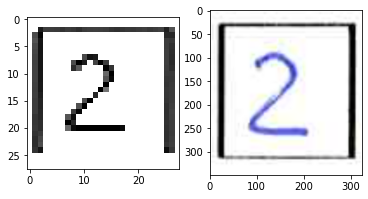

2 0.99987733


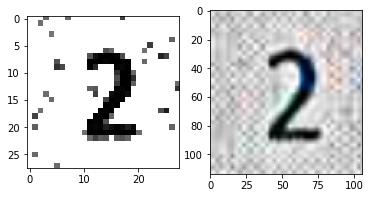

7 0.9851208


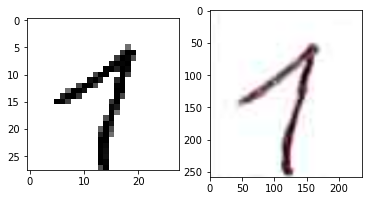

2 0.92122567


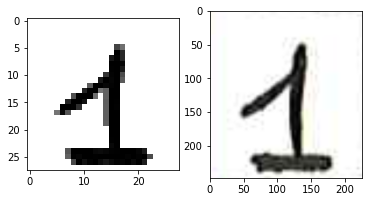

9 0.83847


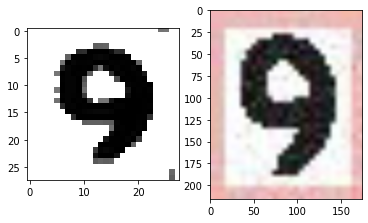

8 0.99999475


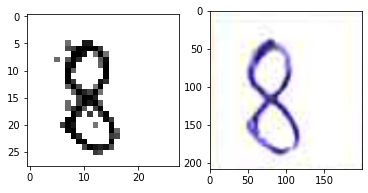

2 0.9999999


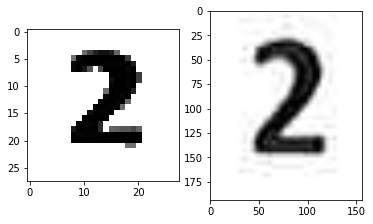

6 0.9963642


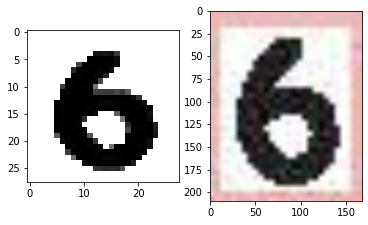

8 0.7552995


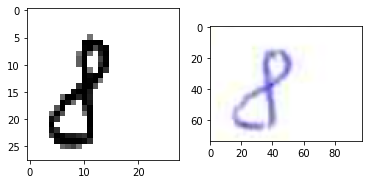

5 0.9968972


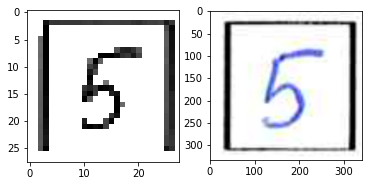

0 0.99999726


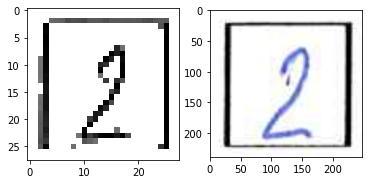

5 0.6017184


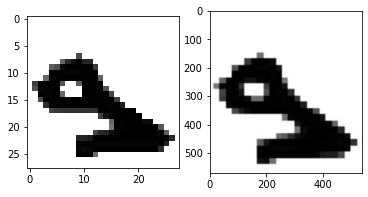

2 0.7064448


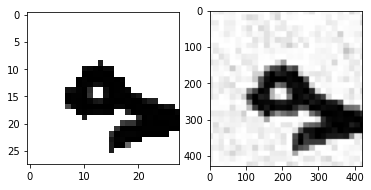

6 0.73445165


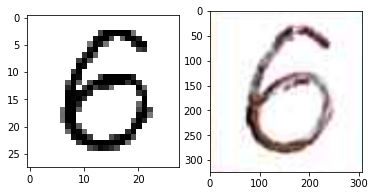

0 0.28592193


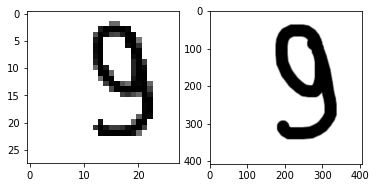

6 0.9999988


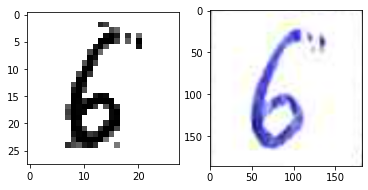

0 0.6843902


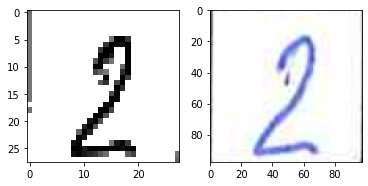

2 0.99988866


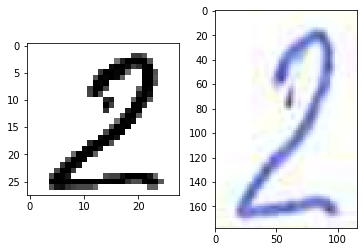

0 1.0


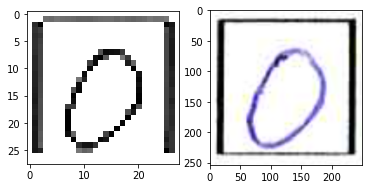

9 0.99917465


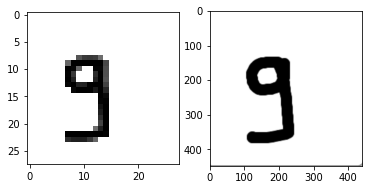

0 0.99999


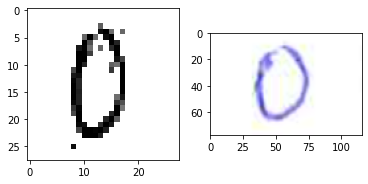

6 1.0


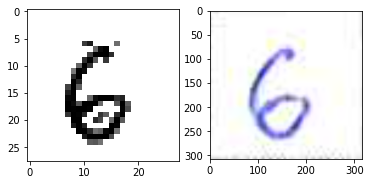

0 0.7369846


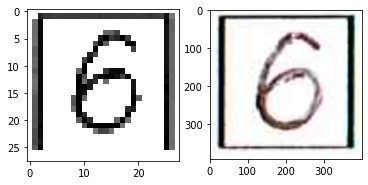

0 1.0


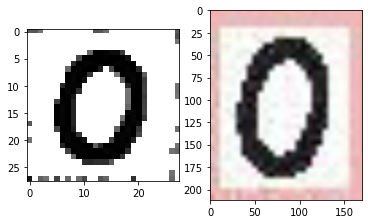

4 1.0


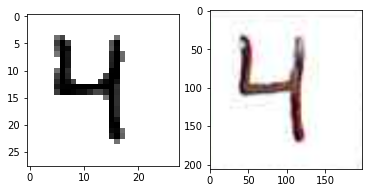

3 0.9997799


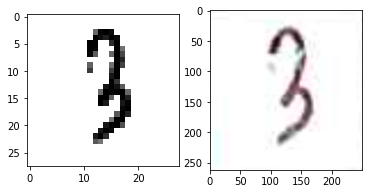

0 0.9998684


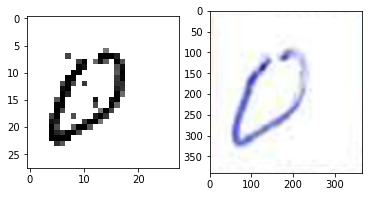

1 1.0


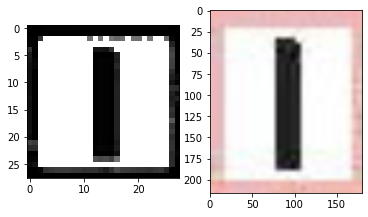

6 1.0


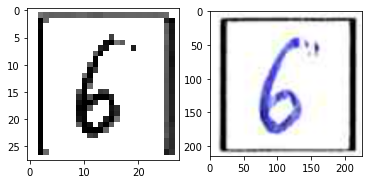

4 0.99696296


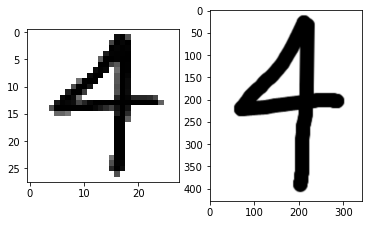

2 0.94853735


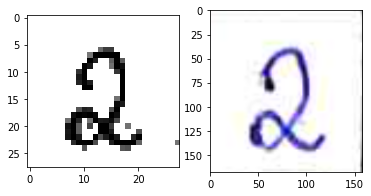

4 0.9941223


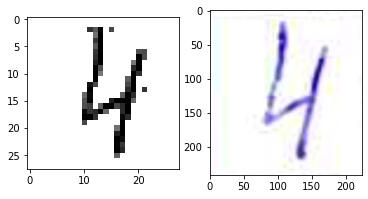

3 0.9999939


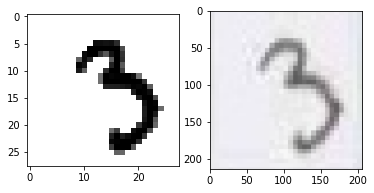

7 0.9895258


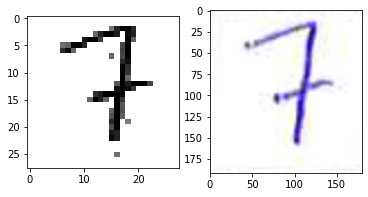

6 0.99998534


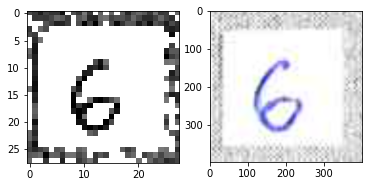

6 1.0


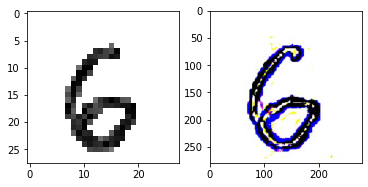

5 1.0


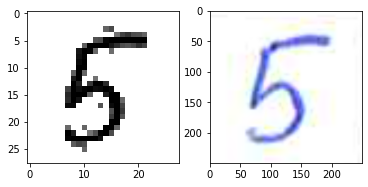

2 1.0


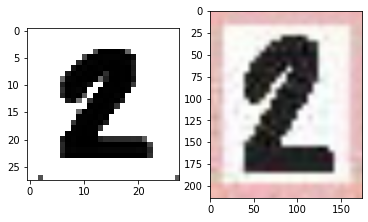

6 0.99999833


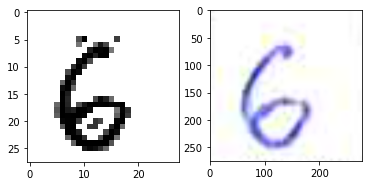

2 0.9998424


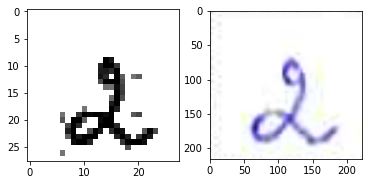

6 1.0


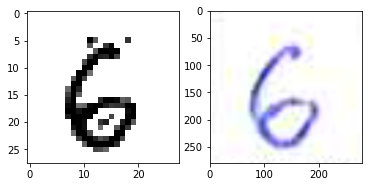

2 0.99848574


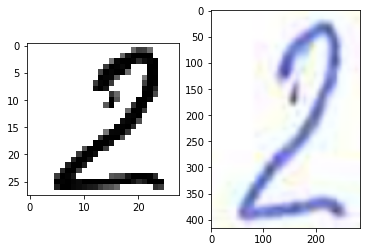

5 0.99982977


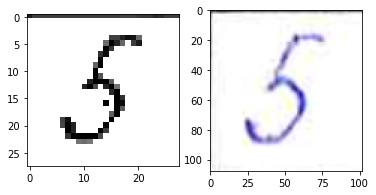

7 0.9226241


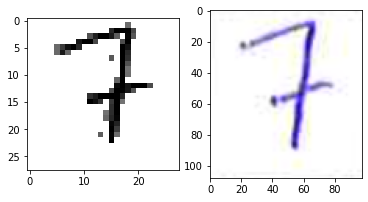

4 0.9995326


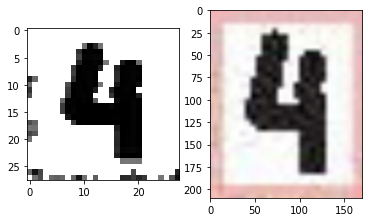

7 0.9908183


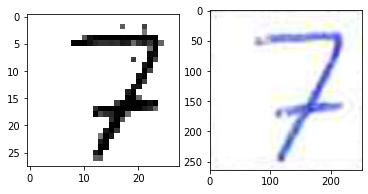

6 0.9999552


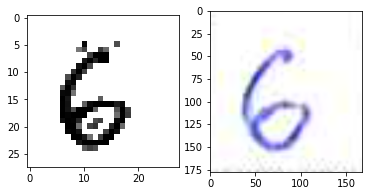

0 1.0


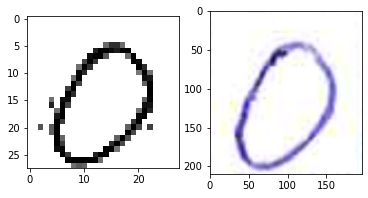

3 1.0


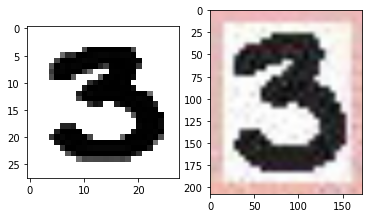

0 1.0


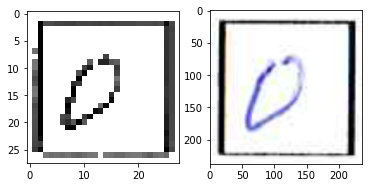

6 0.99896884


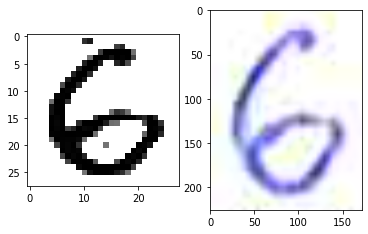

0 0.99977714


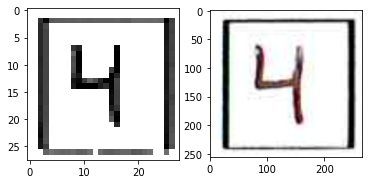

5 1.0


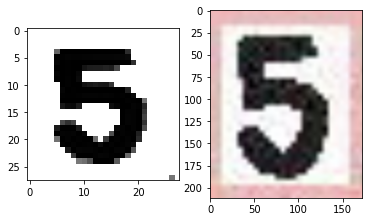

0 1.0


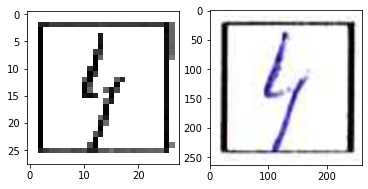

0 0.9990934


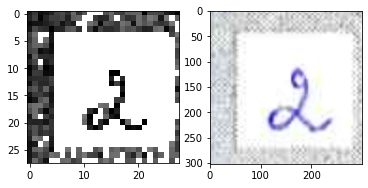

8 0.4163152


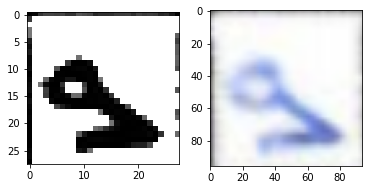

8 0.5630228


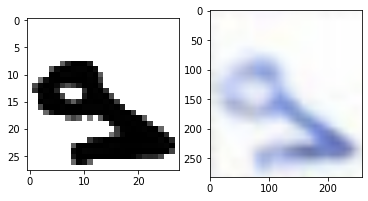

7 0.93857247


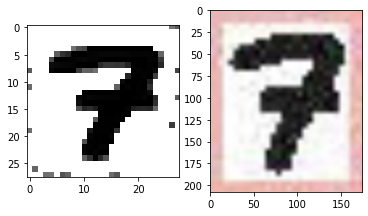

2 0.99994516


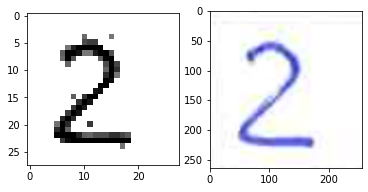

In [0]:
import os
for filename in os.listdir():
    if filename.endswith(".png") or filename.endswith(".jpg"):
        recognize_and_print_digit(filename)